# Validation against analytical solution on spheroid (revolving ellipse)

## Basic setup

In [21]:
import sympy as sp
import numpy as np
import polyscope as ps
import pymem3dg as dg
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.io

a = 1
c = 0.5
e = np.sqrt(1 - c**2/a**2)
sp.init_printing(use_unicode=True)

def myExpFunc(x, a, b):
    """ Expotential function for fitting purpose """
    return a * np.power(x, b)
    
def polyVisualize():
    """ Visualization function using Polyscope """
    ps.init()
    ps_mesh = ps.register_surface_mesh("RBC", coord, topo)
    # ps_mesh.add_scalar_quantity("mean_curvature_diff", abs(H_num - H) )
    # ps_mesh.add_scalar_quantity("gauss_curvature_diff", abs(K_num - K) )
    # ps_mesh.add_scalar_quantity("mean_curvature_num", H_num )
    # ps_mesh.add_scalar_quantity("gauss_curvature_num", K_num )
    # ps_mesh.add_scalar_quantity("mean_curvature", H)
    # ps_mesh.add_scalar_quantity("gauss_curvature",  K)

    # ps_mesh.add_vector_quantity(
    #     "mean_curvature_diff", (H_num - H))
    # ps_mesh.add_vector_quantity(
    #     "gauss_curvature_diff", (K_num - K))
    # ps_mesh.add_scalar_quantity(
    #     "mean_curvature_diff", rowwiseNorm(H_num - H))
    # ps_mesh.add_scalar_quantity(
    #     "gauss_curvature_diff", rowwiseNorm(K_num - K))
    # ps_mesh.add_vector_quantity("mean_curvature_num", H_num)
    # ps_mesh.add_vector_quantity("gauss_curvature_num", K_num)
    # ps_mesh.add_vector_quantity("mean_curvature", H)
    # ps_mesh.add_vector_quantity("gauss_curvature",  K)

    ps_mesh.add_scalar_quantity("geocentric beta",
                                parametricToGeocentricLatitude_pt(parametricBeta))

    ps_mesh.add_scalar_quantity("laplacianH_diff",
                                rowwiseNorm(laplacianH_num - laplacianH) / rowwiseNorm(laplacianH))
    ps_mesh.add_scalar_quantity("laplacianH_cotan_diff",
                                rowwiseNorm(laplacianH - laplacianH_cotan)/rowwiseNorm(laplacianH))
    ps_mesh.add_scalar_quantity(
        "laplacianH", rowwiseNorm(laplacianH))
    # vmin = np.min(rowwiseNorm(laplacianH))
    # vmax = np.max(rowwiseNorm(laplacianH))
    # ps_mesh.add_scalar_quantity(
    #     "laplacianH_num", rowwiseNorm(laplacianH_num),  vminmax=(vmin, vmax))
    # ps_mesh.add_scalar_quantity(
    #     "laplacianH_cotan", rowwiseNorm(laplacianH_cotan), vminmax=(vmin, vmax))
    ps_mesh.add_vector_quantity(
        "laplacianH_num", laplacianH_num)
    ps_mesh.add_vector_quantity(
        "laplacianH", laplacianH)
    ps_mesh.add_vector_quantity(
        "laplacianH_cotan", laplacianH_cotan)

    # ps_mesh.add_scalar_quantity("S_diff",
    #                             rowwiseNorm(S_num - S))
    # ps_mesh.add_vector_quantity(
    #     "S", S_num)
    # ps_mesh.add_vector_quantity(
    #     "S_exact", S)

    ps.set_up_dir("z_up")
    ps.show()


def matplotlibStyle():
    """ Formatting style of matplotlib """
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = "sans-serif"
    # mpl.rcParams.update({'font.size': 8})
    SMALL_SIZE = 7
    MEDIUM_SIZE = 9
    BIGGER_SIZE = 10
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('pdf', fonttype=42)


## Utility functions for mesh generation

In [3]:
def deform(coord):
    """ Deform a spherical mesh to spheroid shape

    Args:
        coord ((n, 3) numpy array): coordinate of original mesh

    Returns:
        coord: coordinate of deformed mesh 
        theta: azimuth coordinate (angle)
        parametricBeta: parametric latitude
    """
    x = coord[:, 0]
    y = coord[:, 1]
    z = coord[:, 2]
    theta = np.arctan2(y, x)
    r = (x**2 + y**2)**0.5
    # not a correct definition!!, but simply assign a parametric beta to the mesh
    parametricBeta = np.arctan(z/r)
    coord[:, 0] = a * np.cos(parametricBeta) * np.cos(theta)
    coord[:, 1] = a * np.cos(parametricBeta) * np.sin(theta)
    coord[:, 2] = c * np.sin(parametricBeta)
    # geocentricBeta = np.arctan(coord[:, 2]/ (coord[:, 0]**2 + coord[:, 1]**2)**0.5)
    return coord, theta, parametricBeta

def getSpheroidMesh(radius, nSub):
    """ Obtain a spheroid mesh directly by wrapping the deform function """
    topo, coord = dg.getIcosphere(radius, nSub)
    coord, theta, parametricBeta = deform(coord)
    return topo, coord, theta, parametricBeta

## Computation of analytical pointwise measurements 

- Mean curvature 
- Gaussian curvature 
- Bi-Laplacian term 
- Normal vector

### Utility functions 

In [4]:
""" helper functions """
def sphericalRadius_sym(geocentricBeta):
    t1 = c * sp.cos(geocentricBeta)
    t2 = a * sp.sin(geocentricBeta)
    return a * c / sp.sqrt(t1**2 + t2**2)

def normalVector_sym_2(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    normalVector = sp.Matrix(
        [[l * sp.cos(geocentricBeta) / a**2, l * sp.sin(geocentricBeta) / c**2]])
    normalVector = normalVector/normalVector.norm()
    return normalVector

def normalVector_sym_3(geocentricBeta, theta):
    l = sphericalRadius_sym(geocentricBeta)
    r_xy = l * sp.cos(geocentricBeta) / a**2
    normalVector = sp.Matrix(
        [[r_xy * sp.cos(theta), r_xy * sp.sin(theta), l * sp.sin(geocentricBeta) / c**2]])
    normalVector = normalVector/normalVector.norm()
    return normalVector

def geocentricToParametricLatitude_sym(geocentricBeta):
    return sp.atan(sp.tan(geocentricBeta) / sp.sqrt(1-e**2))


def parametricToGeocentricLatitude_sym(parametricBeta):
    return sp.atan(sp.tan(parametricBeta) * sp.sqrt(1-e**2))


def geocentricToParametricLatitude_pt(geocentricBeta):
    return np.arctan(np.tan(geocentricBeta) / np.sqrt(1-e**2))


def parametricToGeocentricLatitude_pt(parametricBeta):
    return np.arctan(np.tan(parametricBeta) * np.sqrt(1-e**2))


""" Mean curvature """
def meanCurvature_sym(parametricBeta):
    meanCurvature = c * ((2 * a**2 + (c**2 - a**2) * sp.cos(parametricBeta)**2)) / \
        (2 * a * (a**2 + (c**2 - a**2) * sp.cos(parametricBeta)**2)**(1.5))
    return meanCurvature

def meanCurvature_pt(parametricBeta):
    meanCurvature = np.zeros(np.shape(parametricBeta)[0])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    scalar = meanCurvature_sym(betaSympyVariable)
    for i in range(len(parametricBeta)):
        parametricBeta_i = parametricBeta[i]
        meanCurvature[i] = scalar.subs(
            betaSympyVariable, parametricBeta_i)
    return meanCurvature

def meanCurvatureVec_pt(geocentricBeta, theta):
    meanCurvature = np.zeros([np.shape(parametricBeta)[0], 3])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    vector = (meanCurvature_sym(geocentricToParametricLatitude_sym(betaSympyVariable)) * normalVector_sym_3(betaSympyVariable,
                                                                                                            thetaSympyVariable))
    for i in range(len(parametricBeta)):
        meanCurvature[i] = vector.subs(
            [(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return meanCurvature

""" Gaussian curvature """
def gaussianCurvature_sym(parametricBeta):
    gaussCurvature = c**2 / (a**2 + (c**2 - a**2) *
                             sp.cos(parametricBeta)**2)**2
    return gaussCurvature

def gaussianCurvature_pt(parametricBeta):
    gaussianCurvature = np.zeros(np.shape(parametricBeta)[0])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    scalar = gaussianCurvature_sym(betaSympyVariable)
    for i in range(len(parametricBeta)):
        parametricBeta_i = parametricBeta[i]
        gaussianCurvature[i] = scalar.subs(
            betaSympyVariable, parametricBeta_i)
    return gaussianCurvature

def gaussianCurvatureVec_pt(geocentricBeta, theta):
    gaussianCurvature = np.zeros([np.shape(parametricBeta)[0], 3])
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    betaSympyVariable = sp.symbols('betaSympyVariable')
    vector = (gaussianCurvature_sym(geocentricToParametricLatitude_sym(betaSympyVariable)) * normalVector_sym_3(betaSympyVariable,
                                                                                                                thetaSympyVariable))
    for i in range(len(parametricBeta)):
        gaussianCurvature[i] = vector.subs(
            [(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return gaussianCurvature

""" bi-Laplacian term """
def laplacianOfMeanCurvature_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    dldbeta = sp.diff(l, geocentricBeta)
    dbetads = (l**2 + dldbeta**2)**(-0.5)
    # dbetads = a * c * sp.sqrt(a**4 * sp.sin(geocentricBeta)**2 + c**4 * sp.cos(geocentricBeta)**2) / (a**2 * sp.sin(geocentricBeta)**2 + c**2 * sp.cos(geocentricBeta)**2)**(1.5)
    r = l * sp.cos(geocentricBeta)
    H = meanCurvature_sym(geocentricToParametricLatitude_sym(geocentricBeta))
    return r**(-1) * sp.diff(r * sp.diff(H, geocentricBeta) * dbetads, geocentricBeta) * dbetads


def laplacianOfMeanCurvatureVec_pt(geocentricBeta, theta):
    laplacianH = np.zeros([np.shape(geocentricBeta)[0], 3])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    vector = (laplacianOfMeanCurvature_sym(betaSympyVariable) * normalVector_sym_3(betaSympyVariable,
                                                                                   thetaSympyVariable))
    for i in range(len(geocentricBeta)):
        # if ( abs(abs(geocentricBeta[i]) - (np.pi/2)) > 1e-5 ):
        laplacianH[i] = vector.subs(
            [(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return laplacianH

### Run or load 
Script is either precomputed and reloaded, or can be rerunned. To rerun, do ```rerun = True```

In [5]:
rerun = False

if rerun: 
    nSub = 0
    topo, coord, theta, parametricBeta = getSpheroidMesh(1, nSub)
    geocentricBeta = parametricToGeocentricLatitude_pt(parametricBeta)
    H = meanCurvatureVec_pt(geocentricBeta, theta)
    K = gaussianCurvatureVec_pt(geocentricBeta, theta)
    laplacianH = laplacianOfMeanCurvatureVec_pt(
        geocentricBeta, theta)

    scipy.io.savemat('nSub{}_ptwise.mat'.format(nSub), mdict={
                    'topo': topo, 'coord': coord, "theta": theta, "parametricBeta": parametricBeta, "geocentricBeta": geocentricBeta, "H": H, "K": K, "laplacianH": laplacianH})

x = scipy.io.loadmat('nSub4_ptwise.mat')
topo = x['topo']           
coord = x[ 'coord']         
theta = x[ "theta"]         
parametricBeta = x[ "parametricBeta"]
geocentricBeta = x[ "geocentricBeta"]
H= x[ "H"]             
K= x[ "K"]             
laplacianH= x[ "laplacianH"]    


## Computation of numerical pointwise measurements
- Scalar and vector mean curvature 
- Scalar and vector Gaussian curvature 
- Cotan and Schlafli Bi-Laplacian term 
- Volume gradient 

In [6]:
""" helper functions """
def rowwiseScaling(scaling, matrix):
    if np.shape(matrix)[0] == np.size(matrix):
        return matrix * scaling
    else:
        return matrix * scaling[:, None]


def vertexwiseToIntegrated(system, matrix):
    M = system.getVertexDualArea()
    return rowwiseScaling(M, matrix)


def integratedToVertexwise(system, matrix):
    M_inv = 1 / system.getVertexDualArea()
    return rowwiseScaling(M_inv, matrix)


def cotanLaplacianH(system):
    H = system.getMeanCurvature()
    M_inv = 1 / system.getVertexDualArea()
    scalarH = -M_inv * (system.getCotanLaplacian() @
                        (M_inv * H))
    return scalarH


system = dg.System(topo, coord)
gradV_num = integratedToVertexwise(system, system.getVolumeVariationVector())
H_vec_num = integratedToVertexwise(system, system.getMeanCurvatureVector())
H_scalar_num = integratedToVertexwise(system, system.getMeanCurvature())
K_vec_num = integratedToVertexwise(system, system.getGaussianCurvatureVector())
K_scalar_num = integratedToVertexwise(system, system.getGaussianCurvature())
laplacianH_num = - \
    integratedToVertexwise(system, system.getLaplacianMeanCurvatureVector())
laplacianH_cotan = rowwiseScaling(cotanLaplacianH(
    system), system.getAngleWeightedNormal())


## Visualize the comparison of pointwise measurements on smooth and discrete surfaces 

In [7]:
def inverseMassMatrix(system):
    M_inv = system.getLumpedMassMatrix()
    np.reciprocal(M_inv.data, out=M_inv.data)
    return M_inv


def rowwiseNorm(matrix):
    if np.shape(matrix)[0] == np.size(matrix):
        return np.abs(matrix)
    else:
        return np.sum(matrix**2, axis=1)**(0.5)


def rowwiseNormalize(matrix):
    # print("norm:", rowwiseNorm(matrix))
    return rowwiseScaling(rowwiseNorm(matrix)**(-1), matrix)


def rowwiseDotProduct(a, b):
    return np.sum(a*b, axis=1)

# polyVisualize()

matplotlibStyle()

size = 1

### Vector measurements: $\vec{H}$, $\vec{K}$, and $\vec{\nabla }H$

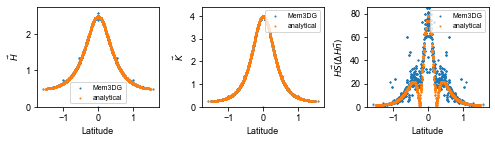

In [8]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(7, 2)

ax_ = ax[0]
ax_.set_xlabel("Latitude")
ax_.set_ylabel('$\\vec{H}$')
ax_.scatter(parametricBeta, rowwiseNorm(H_vec_num), s=size, label="Mem3DG")
ax_.scatter(parametricBeta, rowwiseNorm(H), s=size, label="analytical")
# ax__ = ax_.twinx()
# ax__.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
#     H_vec_num), rowwiseNormalize(H)), s=size, marker="*")
ax_.set_ylim([0, np.max(rowwiseNorm(
    H)) * 1.1])
ax_.legend()


ax_ = ax[1]
ax_.set_xlabel("Latitude")
ax_.set_ylabel("$\\vec{K}$")
ax_.scatter(parametricBeta, rowwiseNorm(K_vec_num), s=size, label="Mem3DG")
ax_.scatter(parametricBeta, rowwiseNorm(K), s=size, label="analytical")
# ax__ = ax_.twinx()
# ax__.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
#     K_vec_num), rowwiseNormalize(K)), s=size, color = 'g',)
ax_.set_ylim([0, np.max(rowwiseNorm(
    K)) * 1.1])
ax_.legend()


ax_ = ax[2]
ax_.set_xlabel("Latitude")
ax_.set_ylabel('$ H \\vec{S} (\\Delta H \\vec{n})$')
ax_.scatter(parametricBeta, rowwiseNorm(
    laplacianH_num), s=size, label="Mem3DG")
ax_.scatter(parametricBeta, rowwiseNorm(
    laplacianH), s=size, label="analytical")
# ax__ = ax_.twinx()
# ax__.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
#     laplacianH_num), rowwiseNormalize(laplacianH)),  color = "g", s=size, marker="*")
ax_.set_ylim([0, np.max(rowwiseNorm(
    laplacianH)) * 1.1])
ax_.legend()

plt.tight_layout()
plt.savefig("pointwise_vector.pdf", transparent=True)
plt.savefig("pointwise_vector.png", transparent=True, dpi=1200)
plt.show()

### Scalar measurements: $H, K,$ and $\nabla H$

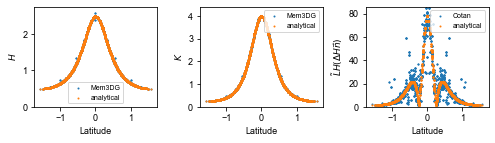

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(7, 2)

ax_ = ax[0]
ax_.set_xlabel("Latitude")
ax_.set_ylabel('$H$')
ax_.scatter(parametricBeta, H_scalar_num, s=size, label="Mem3DG")
ax_.scatter(parametricBeta, rowwiseNorm(H), s=size, label="analytical")
ax_.set_ylim([0, np.max(rowwiseNorm(
    H)) * 1.1])
ax_.legend()

ax_ = ax[1]
ax_.set_xlabel("Latitude")
ax_.set_ylabel('$K$')
ax_.scatter(parametricBeta, K_scalar_num, s=size, label="Mem3DG")
ax_.scatter(parametricBeta, rowwiseNorm(K), s=size, label="analytical")
ax_.set_ylim([0, np.max(rowwiseNorm(
    K)) * 1.1])
ax_.legend()

ax_ = ax[2]
ax_.set_xlabel("Latitude")
ax_.set_ylabel('$\\tilde{L} H (\\Delta H \\vec{n})$')
ax_.scatter(parametricBeta, rowwiseNorm(laplacianH_cotan),
            s=size, label="Cotan")
ax_.scatter(parametricBeta, rowwiseNorm(
    laplacianH), s=size, label="analytical")
ax_.set_ylim([0, np.max(rowwiseNorm(
    laplacianH)) * 1.1])
ax_.legend()

plt.tight_layout()
plt.savefig("pointwise_scalar.pdf", transparent=True)
plt.savefig("pointwise_scalar.png", transparent=True, dpi=1200)
plt.show()

### Direction alignment of $\vec{\nabla} V$, $\vec{H}$, $\vec{K}$, and $\vec{\nabla }H$

C:\Users\Kieran\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()
C:\Users\Kieran\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\Kieran\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


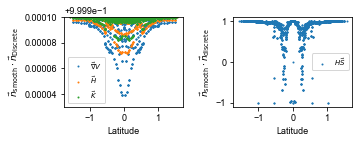

In [10]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(5, 2)

ax_ = ax[0]
ax_.set_xlabel("Latitude")
ax_.set_ylabel("$\\vec{n}_{\mathrm{smooth}} \cdot \\vec{n}_{\mathrm{Discrete}}$")
ax_.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
    gradV_num), rowwiseNormalize(K)), s=size, label="$\\vec{\\nabla} V$")
ax_.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
    H_vec_num), rowwiseNormalize(H)), s=size, label="$\\vec{H}$")
ax_.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
    K_vec_num), rowwiseNormalize(K)), s=size, label="$\\vec{K}$")
# ax_.scatter(parametricBeta, rowwiseDotProduct(
#     system.getAngleWeightedNormal(), rowwiseNormalize(K)), s=size, label="angle")
ax_.set_ylim([0.99993, 1])
# ax_.set_ylim([1, 3])
# ax_.set_yscale('log')
ax_.legend()


# ax_ = ax[3]
# ax_.set_xlabel("Latitude")
# ax_.set_ylabel('$\\Delta H$')
# ax_.scatter(parametricBeta, rowwiseNorm(
#     laplacianH_num), s=size, label="$H \\vec{S}$")
# ax_.scatter(parametricBeta, rowwiseNorm(laplacianH_cotan),
#             s=size, label="Cotan")
# ax_.set_ylim([0, np.max(rowwiseNorm(
#     laplacianH)) * 1.1])
# ax_.legend()
ax_ = ax[1]
ax_.scatter(parametricBeta, rowwiseDotProduct(rowwiseNormalize(
    laplacianH_num), rowwiseNormalize(laplacianH)), s=size, label="$H \\vec{S}$")
# ax_.set_ylim([1, 3])
# ax_.set_yscale('log')
# ax_.set_yticks([])
ax_.set_xlabel("Latitude")
ax_.set_ylabel("$\\vec{n}_{\mathrm{smooth}} \cdot \\vec{n}_{\mathrm{discrete}}$")
ax_.legend()

plt.tight_layout()
plt.savefig("alignment.pdf", transparent=True)
plt.savefig("alignment.png", transparent=True, dpi=1200)
plt.show()

## Computation of analytical solution of integrated measurements
- Area $A$
- Volume $V$
- total mean curvature $\int_{\mathcal{M}} H dA$
- Willmore energy $\int_{\mathcal{M}} H^2 dA$
- total Gaussian curvature $\int_{\mathcal{M}} K dA$

In [15]:
def normalVectorDotCoordinate_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    coordinate = sp.Matrix(
        [[l * sp.cos(geocentricBeta), l * sp.sin(geocentricBeta)]])
    normalVector = normalVector_sym_2(geocentricBeta)
    return coordinate.dot(normalVector)


def wikiExplicitArea():
    return 2 * np.pi * a**2 + np.pi * c**2 / e * math.log((1+e)/(1-e))


def areaElement_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    dldbeta = sp.diff(l, geocentricBeta)
    return 2 * sp.pi * l * sp.cos(geocentricBeta) * sp.sqrt(l**2 + dldbeta**2)


def wikiExplicitVolume():
    return 4 / 3 * np.pi * a**2 * c


def volumeElement_sym(parametricBeta):
    return normalVectorDotCoordinate_sym(parametricBeta) / 3 * areaElement_sym(geocentricBeta)


rerun = False

if rerun:
    geocentricBeta = sp.symbols('geocentricBeta')

    area = sp.Integral(areaElement_sym(geocentricBeta),
                       (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
    area = wikiExplicitArea()

    volume = sp.Integral(volumeElement_sym(geocentricBeta),
                         (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
    volume = wikiExplicitVolume()

    totalMeanCurvature = sp.Integral(meanCurvature_sym(geocentricToParametricLatitude_sym(
        geocentricBeta)) * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
    totalMeanCurvatureSquared = sp.Integral(meanCurvature_sym(geocentricToParametricLatitude_sym(
        geocentricBeta))**2 * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()

    totalGaussianCurvature = sp.Integral(gaussianCurvature_sym(geocentricToParametricLatitude_sym(
        geocentricBeta)) * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()

    scipy.io.savemat('integrated.mat', mdict={
        'area': np.array(area).astype(np.float64), 'volume': np.array(volume).astype(np.float64), "totalMeanCurvature": np.array(totalMeanCurvature).astype(np.float64), "totalMeanCurvatureSquared": np.array(totalMeanCurvatureSquared).astype(np.float64), "totalGaussianCurvature": np.array(totalGaussianCurvature).astype(np.float64)})

x = scipy.io.loadmat('integrated.mat')
area = np.squeeze(x['area'])
volume = np.squeeze(x['volume'])
totalMeanCurvature = np.squeeze(x["totalMeanCurvature"])
totalMeanCurvatureSquared = np.squeeze(x["totalMeanCurvatureSquared"])
totalGaussianCurvature = np.squeeze(x["totalGaussianCurvature"])

print("analytical area: ", area)
print("analytical volume: ", volume)
print("analytical total mean curvature: ", totalMeanCurvature)
print("analytical total mean curvature squared: ", totalMeanCurvatureSquared)
print("analytical total gaussian curvature: ", totalGaussianCurvature)
print("analytical total gaussian curvature from Gauss-Bonnet: ", 4 * np.pi)

# In comparison with the numerical computation from discrete geometry
print("numerical area: ", system.surfaceArea)
print("numerical volume: ", system.volume)
print("numerical total mean curvature: ", np.sum(system.getMeanCurvature()))
print("numerical total mean curvature squared: ", np.sum(
     (system.getMeanCurvature())**2 / system.getVertexDualArea()))
print("numerical total gaussian curvature squared: ",
      np.sum(system.getGaussianCurvature()))


analytical area:  8.671882703345052
analytical volume:  2.0943951023931953
analytical total mean curvature:  10.739217663941869
analytical total mean curvature squared:  16.9023119660317
analytical total gaussian curvature:  12.566370614359174
analytical total gaussian curvature from Gauss-Bonnet:  12.566370614359172
numerical area:  8.661528007212883
numerical volume:  2.089869473997361
numerical total mean curvature:  10.73494364272441
numerical total mean curvature squared:  16.89440776760983
numerical total gaussian curvature squared:  12.566370614358616


## Convergence analysis 
### Convergence of pointwise value using error norm

In [13]:
def getError(analytical, mem3dg, order = 1):
      if order == 1:
            weightedL1Error = np.sum(vertexwiseToIntegrated(system, rowwiseNorm(mem3dg - analytical)))
            return weightedL1Error
      elif order == 2: 
            weightedL2Error = np.sum(vertexwiseToIntegrated(system, rowwiseNorm(mem3dg - analytical)**2))**(0.5)
            return weightedL2Error


print("mean curvature vector error: ", getError(H, H_vec_num))
print("mean curvature scalar error: ",
      getError(rowwiseNorm(H), H_scalar_num))

print("Gaussian curvature vector error: ", getError(K, K_vec_num))
print("Gaussian curvature scalar error: ",
      getError(rowwiseNorm(K), K_scalar_num))

print("Laplcian H Schlafli error: ", getError(rowwiseNorm(laplacianH), rowwiseNorm(laplacianH_num)))
print("Laplcian H cotan error: ", getError(rowwiseNorm(laplacianH), rowwiseNorm(laplacianH_cotan)))


mean curvature vector error:  0.044071199174449974
mean curvature scalar error:  0.027302673465638735
Gaussian curvature vector error:  0.05613778770910187
Gaussian curvature scalar error:  0.03800855407671045
Laplcian H Schlafli error:  48.10221456301924
Laplcian H cotan error:  44.716437974625265


In [18]:
nSubSize = 5
pointwiseLengthScale = 2 ** np.array(list(reversed(range(nSubSize))))

H_vec_error = np.zeros(nSubSize)
K_vec_error = np.zeros(nSubSize)
H_scalar_error = np.zeros(nSubSize)
K_scalar_error = np.zeros(nSubSize)
laplacianH_cotan_error = np.zeros(nSubSize)
laplacianH_schlafli_error = np.zeros(nSubSize)

rerun = False
for i in range(nSubSize):
    if rerun: 
        topo, coord, theta, parametricBeta = getSpheroidMesh(1, i)

        geometricBeta = parametricToGeocentricLatitude_pt(parametricBeta)
        H = meanCurvatureVec_pt(geometricBeta, theta)
        K = gaussianCurvatureVec_pt(geometricBeta, theta)
        laplacianH = laplacianOfMeanCurvatureVec_pt(
            geometricBeta, theta)
    else:
        x = scipy.io.loadmat('nSub{}_ptwise.mat'.format(i))
        topo = x['topo']           
        coord = x[ 'coord']         
        theta = x[ "theta"]         
        parametricBeta = x[ "parametricBeta"]
        geocentricBeta = x[ "geocentricBeta"]
        H= x[ "H"]             
        K= x[ "K"]             
        laplacianH= x[ "laplacianH"]  
    system = dg.System(topo, coord)
    H_vec_num = integratedToVertexwise(
        system, system.getMeanCurvatureVector())
    H_scalar_num = integratedToVertexwise(
        system, system.getMeanCurvature())
    K_vec_num = integratedToVertexwise(
        system, system.getGaussianCurvatureVector())
    K_scalar_num = integratedToVertexwise(
        system, system.getGaussianCurvature())
    laplacianH_num = - \
        integratedToVertexwise(
            system, system.getLaplacianMeanCurvatureVector())
    laplacianH_cotan = rowwiseScaling(cotanLaplacianH(
        system), system.getAngleWeightedNormal())

    H_vec_error[i] = getError(H, H_vec_num)
    H_scalar_error[i] = getError(rowwiseNorm(H), H_scalar_num)
    K_vec_error[i] = getError(K, K_vec_num)
    K_scalar_error[i] = getError(rowwiseNorm(K), K_scalar_num)
    laplacianH_schlafli_error[i] = getError(rowwiseNorm(laplacianH), rowwiseNorm(laplacianH_num))
    laplacianH_cotan_error[i] = getError(rowwiseNorm(laplacianH), rowwiseNorm(laplacianH_cotan))

### Convergence of integrated measurements 

In [19]:
nSubSize = 5
integratedLengthScale =  2 ** np.array(list(reversed(range(nSubSize))))

area_num = np.zeros(nSubSize)
volume_num = np.zeros(nSubSize)
totalMeanCurvature_num = np.zeros(nSubSize)
totalMeanCurvatureSquared_num = np.zeros(nSubSize)
totalGaussianCurvature_num = np.zeros(nSubSize)

for i in range(nSubSize):
    topo, coord, theta, parametricBeta = getSpheroidMesh(1, i+1)
    system = dg.System(topo, coord)
    area_num[i] = system.surfaceArea
    volume_num[i] = system.volume
    totalMeanCurvature_num[i] = np.sum(system.getMeanCurvature())
    totalMeanCurvatureSquared_num[i] = np.sum(
        (system.getMeanCurvature())**2 / system.getVertexDualArea())
    totalGaussianCurvature_num[i] = np.sum(system.getGaussianCurvature())


C:\Users\Kieran\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


### Visualization of convergence properties 

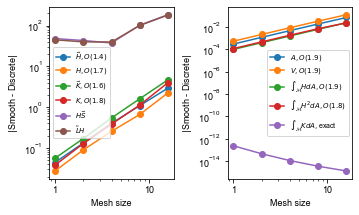

In [20]:
from matplotlib import ticker

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(5, 3)

"""Pointwise measurements"""
ax = axs[0]
ax.set_xlabel("Mesh size")
ax.set_ylabel("$|$Smooth - Discrete$|$")
x = pointwiseLengthScale
error = H_vec_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$\\vec{H}, $"+"$O({{{order: .1f}}})$".format(order=popt[1]))

error = H_scalar_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$H, O({{{order: .1f}}})$".format(order=popt[1]))

error = K_vec_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$\\vec{K}, $"+"$O({{{order: .1f}}})$".format(order=popt[1]))

error = K_scalar_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$K, O({{{order: .1f}}})$".format(order=popt[1]))

error = laplacianH_schlafli_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error, '-o', label="$H \\vec{S}$")

error = laplacianH_cotan_error
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error, '-o', label="$\\tilde{L} H$")
# ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

"""Integrated measurements"""
x = integratedLengthScale
ax = axs[1]
ax.set_xlabel("Mesh size")
ax.set_ylabel("$|$Smooth - Discrete$|$")
error = abs(area_num - area)/abs(area)
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$A, O({{{order: .1f}}})$".format(order=popt[1]))
error = abs(volume_num - volume)/abs(volume)
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$V, O({{{order: .1f}}})$".format(order=popt[1]))
error = abs(totalMeanCurvature_num - totalMeanCurvature) / \
    abs(totalMeanCurvature)
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$\int_{\mathcal{M}} H dA, $" + "$O({{{order: .1f}}})$".format(order=popt[1]))
error = abs(totalMeanCurvatureSquared_num -
            totalMeanCurvatureSquared)/abs(totalMeanCurvatureSquared)
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$\int_{\mathcal{M}} H^2 dA, $" + "$O({{{order: .1f}}})$".format(order=popt[1]))
error = abs(totalGaussianCurvature_num - totalGaussianCurvature) / \
    abs(totalGaussianCurvature)
popt, pcov = curve_fit(myExpFunc, x, error)
ax.loglog(x, error,
          '-o', label="$\int_{\mathcal{M}} K dA, $" + "exact".format(order=popt[1]))

# ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.savefig("convergence.pdf", transparent=True)
plt.savefig("convergence.png", transparent=True, dpi=1200)
plt.show()
